Carrying the same basic concepts as notebook 1 and 2.


The key difference is we will keep 2D structure of images and use convolutions.

We found that POD modes are not the best reduction of the images since the extrapolation performance of the NODE is very poor. Instead, we flatten the full image and try to see if CNNs do any better.

In [1]:
import os
import opinf
import scipy.signal
os.getcwd()

'/home/ajivani/WLROM/WhiteLight'

In [130]:
import numpy as np
from numpy import ogrid
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf as op
import copy

In [3]:
%matplotlib inline

In [4]:
import time

In [5]:
from sunpy.visualization import colormaps as cm

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
adjoint=True

In [8]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cuda', index=0)

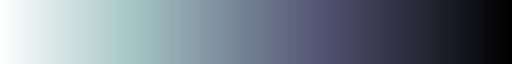

In [11]:
lc3 = cm.cmlist['soholasco3'].reversed()
lc3

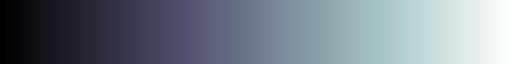

In [12]:
lc3_reg = cm.cmlist['soholasco3']
lc3_reg

In [13]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)

In [14]:
import sys
sys.path.insert(1, '/home/ajivani/WLROM/EdgeSS')

In [15]:
import edge_utils as edut

### Setup training and testing data

In [16]:
X_orig = np.load("./CR2161_tDecay2h_Polar_Compressed.npy")

In [17]:
X = X_orig.reshape((64 * 256, 90, 278))[:, :, :]

In [18]:
X.shape

(16384, 90, 278)

In [19]:
sid=0

In [20]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [21]:
tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx=sid)

In [22]:
tMinIdx

11

In [23]:
all_times = np.linspace(2, 180, 90)

In [24]:
valid_times = np.arange(tMin, tMax + 2, step=2)
valid_times

array([ 24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,
        68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,
        90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.,
       112., 114., 116., 118., 120., 122., 124., 126., 128., 130., 132.,
       134., 136., 138., 140., 142., 144., 146., 148., 150., 152., 154.,
       156., 158., 160.])

In [25]:
validTimeStartIdx = np.argwhere(all_times == valid_times[0])[0][0]
validTimeStartIdx

11

In [26]:
tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
tTrainEnd

114.0

In [27]:
trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
trainEndIdx

45

In [28]:
trainEndIdxAllTimes = np.argwhere(all_times == tTrainEnd)[0][0]
trainEndIdxAllTimes

56

In [29]:
tTrain = valid_times[:(trainEndIdx + 1)]

In [30]:
tTest = valid_times[(trainEndIdx + 1):]
tTest

array([116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150., 152., 154., 156., 158.,
       160.])

In [31]:
tTrainScaled = (tTrain - tMin) / (tMax - tMin)
tTestScaled = (tTest - tMin) / (tMax - tMin)

tAllScaled = (valid_times - tMin) / (tMax - tMin)

In [32]:
nTrain = len(tTrain)
nTrain

46

In [33]:
# Slice data for a particular sID!

x_train_orig = X_orig[:, :, validTimeStartIdx:(trainEndIdxAllTimes + 1), sid]
x_train_orig = x_train_orig.transpose((2, 0, 1))

In [34]:
x_train_orig.shape

(46, 64, 256)

In [35]:
x_train_orig_torch = torch.from_numpy(np.expand_dims(np.float32(x_train_orig), axis=1)).to(device)
x_train_orig_torch.shape

torch.Size([46, 1, 64, 256])

In [39]:
x_train_orig_torch[0][0].shape

torch.Size([64, 256])

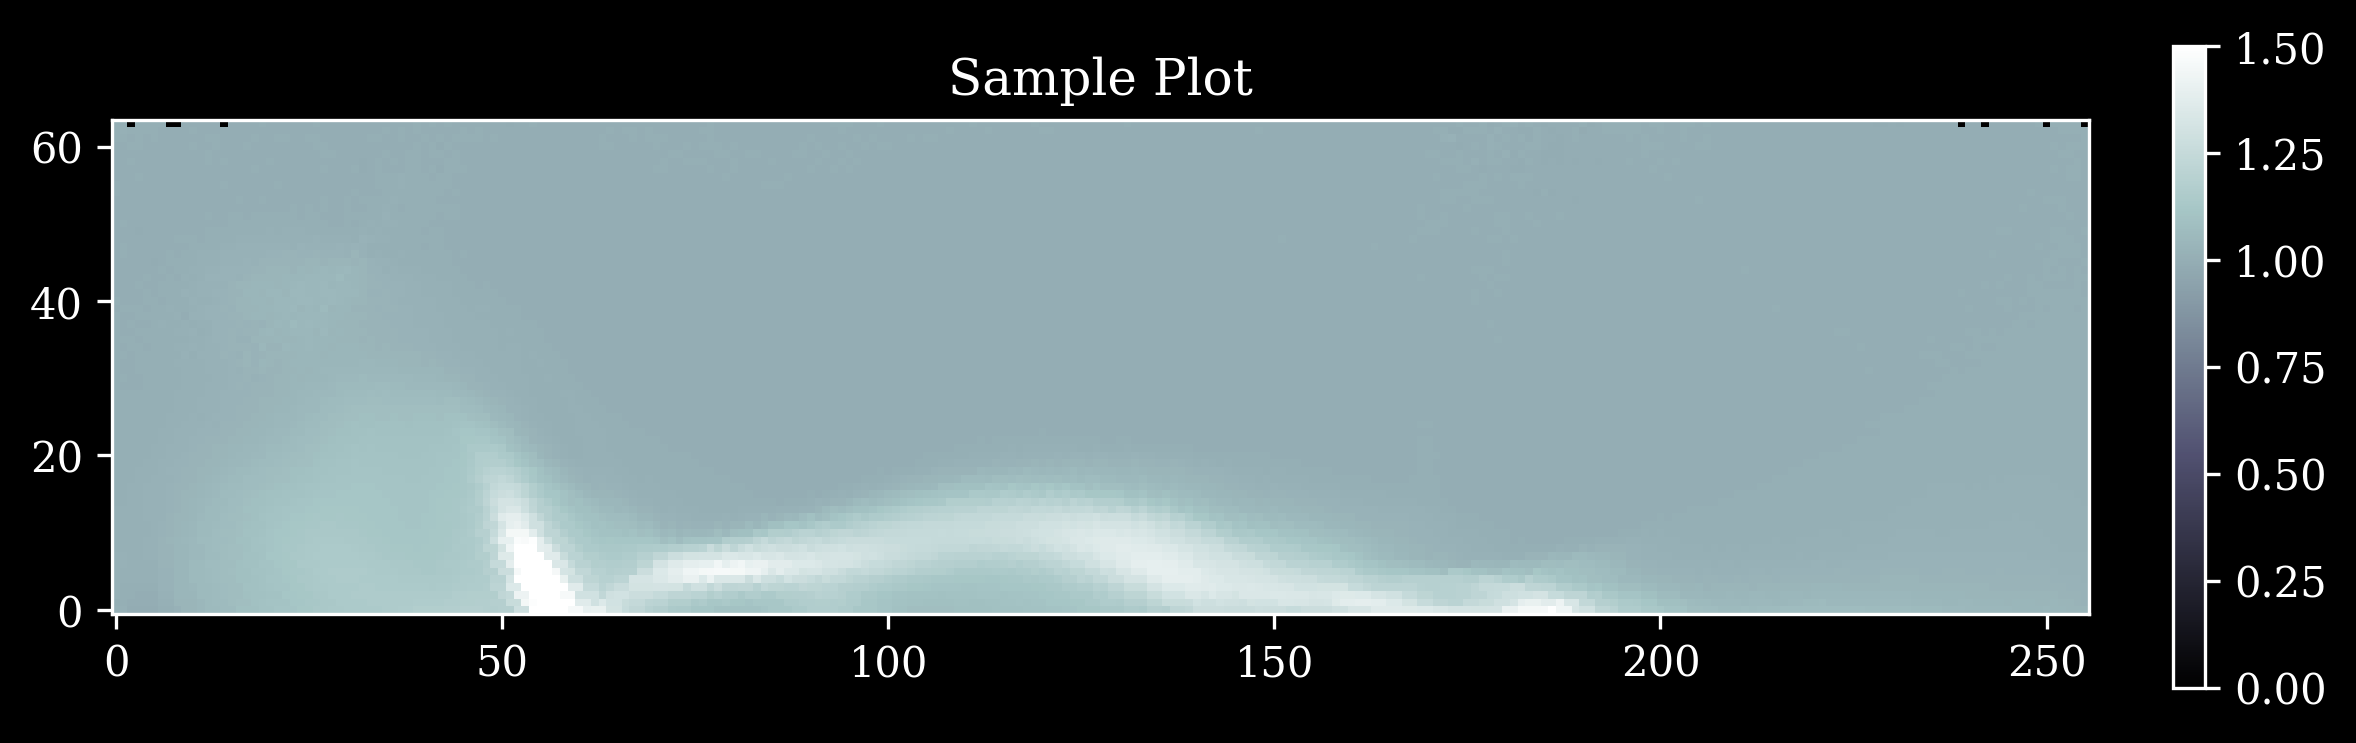

In [41]:
# plot and check to confirm right dimensions have been indexed?
plt.imshow(x_train_orig_torch[20][0].cpu(),
            origin="lower",
            cmap=lc3_reg)
plt.title("Sample Plot")
plt.colorbar(fraction=0.046 * 1/3, pad=0.04)

In [42]:
x_train_flat = X[:, validTimeStartIdx:(trainEndIdxAllTimes + 1), sid]
x_train_flat = x_train_flat.transpose((1, 0))
x_train_flat.shape

(46, 16384)

In [43]:
x_train_flat_torch = torch.from_numpy(np.expand_dims(np.float32(x_train_flat), axis=1)).to(device)
x_train_flat_torch.shape

torch.Size([46, 1, 16384])

In [44]:
x0_train_orig = x_train_orig[tMinIdx, :, :]
x0_train_orig.shape

(64, 256)

In [45]:
x0_train_orig_torch = torch.from_numpy(np.expand_dims(np.float32(x0_train_orig), axis=(0, 1))).to(device)
x0_train_orig_torch.shape

torch.Size([1, 1, 64, 256])

In [46]:
x0_train_flat = x0_train_orig.flatten()
x0_train_flat_torch = torch.from_numpy(np.float32(x0_train_flat)).reshape((1, len(x0_train_flat))).to(device)
x0_train_flat_torch.shape

torch.Size([1, 16384])

In [47]:
t_train_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
t_train_torch.shape

torch.Size([46])

In [48]:
data_size = t_train_torch.shape[0]
batch_time = 5
batch_size = 10

In [49]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64),
                                          batch_size, replace=False))
    batch_y0 = x_train_orig_torch[[s]]
    batch_t = t_train_torch[:batch_time]  # (T)
    batch_y = torch.stack([x_train_flat_torch[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [50]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

### Construction of CNN Architecture

In [51]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [52]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

In [53]:
def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)

In [119]:
class ODEfuncTrial(nn.Module):
    """
    Trial and error for architecture of the ODEfunc with convolutions!
    """
    
    def __init__(self):
        super(ODEfuncTrial, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,
                             out_channels=1,
                             kernel_size=3,
                             stride=1,
                             padding=1
                              )
        
        self.relu1 = nn.ReLU()
        self.mp = nn.MaxPool2d(kernel_size=1)
        
        self.norm1 = norm(1)
        self.relu2 = nn.ReLU(inplace=True)
        self.flat = nn.Flatten()
        #         self.lin1 = nn.Linear(16384, 16384)
        
    def forward(self, t, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.mp(out)
        out = self.norm1(out)
        out = self.relu2(out)
        out = self.flat(out)
        #         out = self.lin1(out)
        out = self.relu1(out)
        
        return out

In [120]:
func2 = ODEfuncTrial().to(device)

In [121]:
by0, bt, by = get_batch()

In [127]:
by0.shape

torch.Size([10, 1, 64, 256])

In [147]:
by0_unsqueeze = torch.unsqueeze(by0, 1)
by0_unsqueeze.shape

torch.Size([10, 1, 1, 64, 256])

In [123]:
bt.shape

torch.Size([5])

In [162]:
lll = []
for i in range(10):
    lll.append(by0[i, :, :, :])

In [164]:
by0_tuple = tuple(lll)
by0_tuple[3].shape

torch.Size([1, 64, 256])

In [166]:
class ODEBlock(nn.Module):

    def __init__(self, odefunc, integration_time):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = integration_time

    def forward(self, x):
        #         self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=1e-3, atol=1e-3)
        return out[1]

#     @property
#     def nfe(self):
#         return self.odefunc.nfe

#     @nfe.setter
#     def nfe(self, value):
#         self.odefunc.nfe = value

In [167]:
func3 = ODEBlock(func2, bt).to(device)

In [169]:
# func3(by0_tuple)
func3(by0)

RuntimeError: The size of tensor a (16384) must match the size of tensor b (256) at non-singleton dimension 3

`odeint` uses `dopri5` or the Dormand-Prince method, a member of the Runge-Kutta family of ODE solvers. It's the default solver under the hood for say, `ode45` in MATLAB.

Many other solver options are also available in `odeint`, including `AdaptiveHeun`, `Fehlberg`, `Euler`, `RK4`, `AdamsBashforth` etc.

In [149]:
# odeint(func2, by0_tuple, bt)
odeint(func2, by0, bt)

RuntimeError: The size of tensor a (16384) must match the size of tensor b (256) at non-singleton dimension 3

In [125]:
ttt_trial = torch.stack((lll))
ttt_trial = torch.unsqueeze(ttt_trial, 1)
ttt_trial = torch.unsqueeze(ttt_trial, 1)
ttt_trial.shape

torch.Size([10, 1, 1, 1, 1, 64, 256])

In [135]:
x_train_orig2 = np.expand_dims(copy.deepcopy(x_train_orig)[:10, :, :], axis=1)

In [136]:
x_train_orig2.shape

(10, 1, 64, 256)

In [ ]:
x_train_tot = []

In [129]:
# odeint(func2, by0, bt).to(device)

In [77]:
by.shape

torch.Size([5, 10, 1, 16384])

In [155]:
# ttr = torch.rand((1, 1, 64, 256)).to(device)

In [154]:
# ttr_transformed = func2(ttr).cpu()
# ttr_transformed.shape

In [153]:
# plot random tensor and see results of convolution

In [152]:
# plt.imshow(ttr[0][0].cpu(),
#             origin="lower",
#             cmap=lc3_reg)
# plt.title("Orig Random Tensor")
# plt.colorbar(fraction=0.046 * 1/3, pad=0.04)

In [151]:
# ttr_transformed.detach().numpy().shape

In [150]:
# plt.imshow(ttr_transformed.detach().numpy().reshape((64, 256)),
#             origin="lower",
#             cmap=lc3_reg)
# plt.title("Transformed Tensor")
# plt.colorbar(fraction=0.046 * 1/3, pad=0.04)

In [ ]:
func2(by0)

In [ ]:
func2()

In [90]:
class ODEfunc(nn.Module):

    def __init__(self):
        super(ODEfunc, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,
                             out_channels=1,
                             kernel_size=3,
                             stride=1,
                             padding=1
                              )
        
        self.relu1 = nn.ReLU()
        self.mp = nn.MaxPool2d(kernel_size=1)
        
        self.norm1 = norm(1)
        self.relu2 = nn.ReLU(inplace=True)
        self.flat = nn.Flatten()
        #         self.lin1 = nn.Linear(16384, 16384)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.mp(out)
        out = self.norm1(out)
        out = self.relu2(out)
        out = self.flat(out)
        #         out = self.lin1(out)
        out = self.relu1(out)
        
        return out

In [ ]:
ii = 0
func = ODEfunc().to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

In [ ]:
func

In [ ]:
niters = 4000
test_freq = 5

In [ ]:
func(t_train_torch, by0)

In [ ]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

step_loss = []
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    step_loss.append(loss.item())
    
    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
#             visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()

In [ ]:
# torch.save(func.state_dict(), "dydt_Ay_Hyy_4000_steps.pt")

**good point**: is it even a good idea to train two nets simultaneously by just taking naive sum of predictions and plugging into loss? see responses on: https://stackoverflow.com/questions/67872719/is-it-possible-to-combine-2-neural-networks

Effectively, we have two things to check over here:

1. What is the error within the training set, if we provide initial condition y0?

2. What is the error on the held out part of the data with the same IC?

We could just plot the 2D images and check this qualitatively / with RMSE, with the caveat that RMSE is not really the metric we want to be optimizing for. Also is evaluating error between reduced _as opposed to_ full state appropriate?

If we tried everything with train times in first sim  i.e. `true_y` was derived from reduced states constructed off `X_train_ttrain[:, :, 0]` then `X_train_ttrain[:, :, 0]` is basically decoded shape for the `true_y`.

Predicted `y` i.e. `pred_y` needs to be decoded.

In [ ]:
with torch.no_grad():
    pred_y = odeint(func, true_y0, t)

In [ ]:
pred_y.shape

In [ ]:
pred_y_np = pred_y.cpu().numpy()[:, 0, :].T

In [ ]:
pred_y_decoded = basis_1.decode(pred_y_np)

In [ ]:
true_y_decoded = X_train_ttrain[:, :, 0]

In [ ]:
pred_y_decoded.shape

visualization for if we are able to replicate training properly.

In [ ]:
64 * 256

In [ ]:
# def visualize():
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
axs = ax.ravel()
im0 = axs[0].imshow(true_y_decoded[:, 40].reshape(64, 256),
            origin="lower",
            cmap=lc3_reg)
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04)

im1 = axs[1].imshow(pred_y_decoded[:, 40].reshape(64, 256),
                   origin="lower",
                   cmap=lc3_reg)
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04)

by comparison to notebook 1?



testing times comparison to notebook 1?

In [ ]:
t_full = torch.tensor(np.float32(t_vec)).to(device)

In [ ]:
with torch.no_grad():
    pred_y_train_sim_fullt = odeint(func, true_y0, t_full)

In [ ]:
pred_y_train_sim_fullt_decoded = basis_1.decode(pred_y_train_sim_fullt.cpu().numpy()[:, 0, :].T)

In [ ]:
pred_y_train_sim_fullt_decoded.shape

In [ ]:
true_y_decoded_fullt = X[:, :, 0]
true_y_decoded_fullt.shape

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
axs = ax.ravel()
im0 = axs[0].imshow(true_y_decoded_fullt[:, 70].reshape(64, 256),
            origin="lower",
            cmap=lc3_reg)
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04)

im1 = axs[1].imshow(pred_y_train_sim_fullt_decoded[:, 70].reshape(64, 256),
                   origin="lower",
                   cmap=lc3_reg)
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04)

Try the same example but with prior learnt OpInf model.

#### Scratch Start

In [ ]:
32 * (32 + 1) / 2

In [ ]:
np.outer([1, 2, 3, 4], [2, 3, 4, 5])

In [ ]:
np.tril_indices(4)

In [ ]:
v_out_flat = np.outer([1, 2, 3, 4], [2, 3, 4, 5])[np.tril_indices(4)]
v_out_flat

In [ ]:
torch.tensor(v_out_flat)

In [ ]:
vquad_t = torch.from_numpy(np.float32(v_out_flat)).reshape((1, len(v_out_flat))).to(device)

In [ ]:
v_np = vquad_t.cpu().numpy().flatten()

In [ ]:
v_np

In [ ]:
# test bed for getting quadratic term in neural net implemented
aaa = np.array([[[1, 2, 3]],
               [[10, 11, 12]]
               ])
aaa


aaa[0, :, :]


sq = np.squeeze(aaa, axis=1)

def qy3(y):
    y_np = np.squeeze(y, axis=1)
    y_np_quad = np.zeros((y_np.shape[0], int(y_np.shape[1] * (y_np.shape[1] + 1)/2)))
    for i in range(y_np.shape[0]):
        y_np_quad[i, :] = np.outer(y_np[i, :], y_np[i, :])[np.tril_indices(y_np.shape[1])]

    y_t_quad = torch.from_numpy(np.expand_dims(np.float32(y_np_quad), axis=1)).to(device)

    return y_t_quad

qy3(aaa)

aaat = qy3(aaa)
aaat.shape

#### Scratch End